In [1]:
%reload_ext autoreload
%autoreload 2


In [175]:
import numpy as np
import torch


seed = 1712
np.random.seed(seed)
torch.manual_seed(seed)

In [176]:
hidden_channels = 32
num_gnn_layers = 3
is_edge_update = True

In [ ]:
num_rounds = 250
eval_round = 0
batch_size = 16
num_train = 300

num_test = 200
num_eval = 500

lr = 5e-3
step_size = 10
gamma = 0.8

client_fraction = 1.0

num_epochs_cen = 200
cen_lr = 5e-4

In [200]:
num_ue = 6
num_ap = 30
num_antenna = 1
tau=20; power_f=0.2; D=1; f=1900; Hb=15; Hm=1.65; d0=0.01;d1=0.05;


noise_p = 10**((-203.975+10*np.log10(20*10**6)+9)/10);
rho_d = power_f/noise_p
rho_p = power_f/noise_p

In [201]:
num_clients = num_ap
eval_round = eval_round if eval_round else num_rounds//10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create Data

In [202]:
from Utils.data_gen import create_graph, build_loader
from torch_geometric.loader import DataLoader




In [203]:
import scipy.io

file_name = f'dl_data_2000_{num_ue}_{num_ap}'
mat_data = scipy.io.loadmat('Data/' + file_name + '.mat')
beta_all = mat_data['betas']
phi_all = mat_data['Phii_cf'].transpose(0, 2, 1)
opt_train_rates = mat_data['R_cf_opt_min'][0]

beta_mean = np.mean(beta_all)
beta_std = np.std(beta_all)
beta_all = (beta_all - beta_mean) / (beta_std)

perm = np.random.RandomState(seed).permutation(beta_all.shape[0])
train_idx = perm[:num_train]
test_idx  = perm[num_train: num_train + num_test]
Beta_all, Phi_all = beta_all[train_idx], phi_all[train_idx]
train_data = create_graph(Beta_all, Phi_all, beta_mean, beta_std, 'het')
train_loader = build_loader(train_data, batch_size, seed=seed, drop_last=True)

Beta_test, Phi_test = beta_all[test_idx], phi_all[test_idx]
test_data = create_graph(Beta_test, Phi_test, beta_mean, beta_std, 'het')
test_loader = build_loader(test_data, batch_size, seed=seed, drop_last=True)

# Init Model

In [204]:
from Models.GNN import APHetNet
from torch.optim.lr_scheduler import StepLR


In [205]:
# Model Meta
ap_dim = train_data[0][0]['AP'].x.shape[1]
ue_dim = train_data[0][0]['UE'].x.shape[1]
edge_dim = train_data[0][0]['down'].edge_attr.shape[1]
tt_meta = [('UE', 'up', 'AP'), ('AP', 'down', 'UE')]
dim_dict = {
    'UE': ue_dim,
    'AP': ap_dim,
    'edge': edge_dim,
}

# Initialize the models, optimizers, and schedulers for clients
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = APHetNet(
    metadata=tt_meta,
    dim_dict=dim_dict,
    out_channels=hidden_channels,
    num_layers=num_gnn_layers,
    hid_layers=hidden_channels,
    edge_conv=is_edge_update
).to(device)

local_models, optimizers, schedulers = [], [], []
for _ in range(num_clients):
    model = APHetNet(
        metadata=tt_meta,
        dim_dict=dim_dict,
        out_channels=hidden_channels,
        num_layers=num_gnn_layers,
        hid_layers=hidden_channels,
        edge_conv=is_edge_update
    ).to(device)
    model.load_state_dict(global_model.state_dict())
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    local_models.append(model)
    optimizers.append(optimizer)
    schedulers.append(scheduler)

In [206]:
from Utils.decentralized_train import FedAvg
fed = FedAvg(client_fraction=client_fraction)

# Centralized Model

In [261]:
from Utils.centralized_train import cen_eval, cen_train, cen_loss_function
from Models.GNN import APHetNet
torch.set_default_dtype(torch.float64) 

num_gnn_layers = 5
num_epochs_cen = 1000
cen_lr = 5e-3 # 5e-3  the the best results
batch_size = 16
hidden_channels = 128 # min 32

In [262]:
train_data_cen = create_graph(Beta_all, Phi_all, beta_mean, beta_std, 'het', isDecentralized=False)
train_loader_cen = DataLoader(train_data_cen, batch_size=batch_size, shuffle=True)
test_data_cen = create_graph(Beta_test, Phi_test, beta_mean, beta_std, 'het', isDecentralized=False)
test_loader_cen = DataLoader(test_data_cen, batch_size=batch_size, shuffle=False)

In [263]:
cen_model = APHetNet(
    metadata=tt_meta,
    dim_dict=dim_dict,
    out_channels=hidden_channels,
    num_layers=num_gnn_layers,
    hid_layers=8,
    edge_conv=True
).to(device)
# cen_optimizer = torch.optim.Adam(cen_model.parameters(), lr=cen_lr)
cen_optimizer = torch.optim.AdamW(cen_model.parameters(), lr=cen_lr, weight_decay=1e-5)
# cen_scheduler = StepLR(cen_optimizer, step_size=50, gamma=0.6)
cen_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    cen_optimizer, T_max=num_epochs_cen, eta_min=5e-5
)

In [264]:
all_rate = []
all_rate_test = []
eval_epochs_cen = num_epochs_cen//10 if num_epochs_cen//10 else 1
print(f'Training Centralized GNN for benchmark...')
for epoch in range(num_epochs_cen):
    cen_model.train()
    train_loss = cen_train(
        train_loader_cen, cen_model, cen_optimizer,
        tau=tau, rho_p=rho_p, rho_d=rho_d, num_antenna=num_antenna
    )
    
    cen_model.eval()
    with torch.no_grad():
        train_eval = cen_eval(
            train_loader_cen, cen_model,
            tau=tau, rho_p=rho_p, rho_d=rho_d, num_antenna=num_antenna
        )
        test_eval = cen_eval(
            test_loader_cen, cen_model,
            tau=tau, rho_p=rho_p, rho_d=rho_d, num_antenna=num_antenna
        )
    all_rate.append(train_eval)    
    all_rate_test.append(test_eval)    
    cen_scheduler.step()
    if epoch%eval_epochs_cen==0:
        print(
            f"Epoch {epoch+1:03d}/{num_epochs_cen} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Rate: {train_eval:.4f} | "
            f"Test Rate: {test_eval:.4f} "
        )

Training Centralized GNN for benchmark...
Epoch 001/1000 | Train Loss: -0.6289 | Train Rate: 0.6279 | Test Rate: 0.6802 
Epoch 101/1000 | Train Loss: -1.2089 | Train Rate: 1.2061 | Test Rate: 1.0466 
Epoch 201/1000 | Train Loss: -1.2733 | Train Rate: 1.2915 | Test Rate: 1.0421 
Epoch 301/1000 | Train Loss: -1.3285 | Train Rate: 1.3210 | Test Rate: 1.0305 
Epoch 401/1000 | Train Loss: -1.3510 | Train Rate: 1.3640 | Test Rate: 0.9999 
Epoch 501/1000 | Train Loss: -1.3907 | Train Rate: 1.3932 | Test Rate: 0.9931 
Epoch 601/1000 | Train Loss: -1.4141 | Train Rate: 1.4144 | Test Rate: 0.9625 
Epoch 701/1000 | Train Loss: -1.4354 | Train Rate: 1.4356 | Test Rate: 0.9424 
Epoch 801/1000 | Train Loss: -1.4523 | Train Rate: 1.4527 | Test Rate: 0.9224 
Epoch 901/1000 | Train Loss: -1.4629 | Train Rate: 1.4634 | Test Rate: 0.9093 


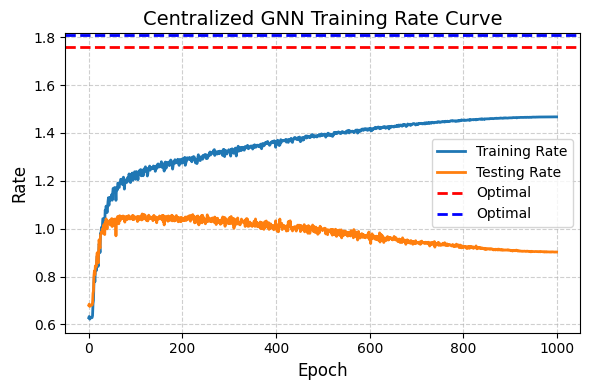

In [265]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(all_rate, label='Training Rate', linewidth=2)
plt.plot(all_rate_test, label='Testing Rate', linewidth=2)
plt.axhline(y=np.mean(opt_train_rates[train_idx]), linewidth=2, color='r', linestyle='--', label='Optimal')
plt.axhline(y=np.mean(opt_train_rates[test_idx]), linewidth=2, color='b', linestyle='--', label='Optimal')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Rate', fontsize=12)
plt.title('Centralized GNN Training Rate Curve', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation

In [255]:
print('Different data eval...')
num_eval = 500
file_name = f'dl_data_2000_{num_ue}_{num_ap}'
# file_name = f'cf_data_1000_{num_ue}_{num_ap}'
# file_name = 'cf_data_1000_6_30'
# file_name = f'eval_data_{num_eval}_{num_ue}_{num_ap}'
eval_mat = scipy.io.loadmat('Data/' + file_name + '.mat')
Beta_eval = eval_mat['betas'][:num_eval]
Phi_eval = eval_mat['Phii_cf'][:num_eval].transpose(0,2,1)

opt_rates = eval_mat['R_cf_opt_min'][:, :num_eval]

beta_mean_eval = np.mean(Beta_eval)
beta_std_eval = np.std(Beta_eval)
Beta_eval = (Beta_eval - beta_mean_eval) / (beta_std_eval)

eval_data = create_graph(Beta_eval, Phi_eval, beta_mean_eval, beta_std_eval,  'het')
eval_loader = build_loader(eval_data, num_eval, seed=1712, drop_last=True)

eval_data_cen = create_graph(Beta_eval, Phi_eval, beta_mean_eval, beta_std_eval, 'het', isDecentralized=False)
eval_loader_cen = DataLoader(eval_data_cen, batch_size=num_eval, shuffle=True)  



Different data eval...


In [192]:
# num_eval = num_test
# train_idx = perm[:num_train]
# test_idx  = perm[num_train: num_train + num_test]
# Beta_all, Phi_all = beta_all[test_idx], phi_all[test_idx]
# eval_data = create_graph(Beta_all, Phi_all, beta_mean, beta_std, 'het')
# eval_loader = build_loader(eval_data, num_train, seed=seed, drop_last=True)

# eval_data_cen = create_graph(Beta_all, Phi_all, beta_mean, beta_std, 'het', isDecentralized=False)
# eval_loader_cen = DataLoader(eval_data_cen, batch_size=num_eval, shuffle=True)  
# opt_rates = opt_train_rates[test_idx]


In [193]:
cen_model.eval()
for batch in eval_loader_cen:
    batch = batch.to(device)
    num_graph = batch.num_graphs
    x_dict, edge_dict, edge_index = cen_model(batch)
    
    gnn_rates, all_one_rates = cen_loss_function(
        batch, x_dict, edge_dict,
        tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna, 
        eval_mode=True
    )

gnn_rates = gnn_rates.detach().cpu().numpy() 
all_one_rates = all_one_rates.detach().cpu().numpy() 

In [194]:
print(f'Avg rate centralized: {np.mean(gnn_rates):0.4f}')
print(f'Avg rate opt: {np.mean(opt_rates):0.4f}')

Avg rate centralized: 0.9900
Avg rate opt: 1.7672


In [195]:
max_value = np.ceil(max(np.max(all_one_rates), np.max(gnn_rates), np.max(opt_rates))*100)/100

In [196]:
num_eval = num_eval
min_rate, max_rate = 0, max_value
# y_axis = np.arange(0, 1.0, 1/202)
y_axis = np.linspace(0, 1, num_eval+2)
gnn_rates.sort();  opt_rates.sort(); all_one_rates.sort();
gnn_rates = np.insert(gnn_rates, 0, min_rate); gnn_rates = np.insert(gnn_rates,num_eval+1,max_rate)
all_one_rates = np.insert(all_one_rates, 0, min_rate); all_one_rates = np.insert(all_one_rates,num_eval+1,max_rate)
opt_rates = np.insert(opt_rates, 0, min_rate); opt_rates = np.insert(opt_rates,num_eval+1,max_rate)

# Visualization

In [197]:
import matplotlib.pyplot as plt


# Check the fucking power thresh

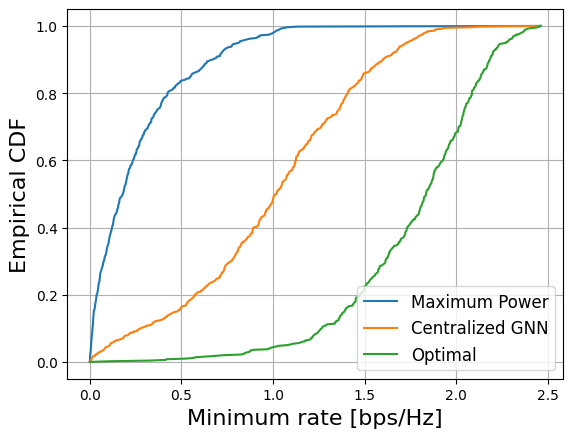

In [198]:
plt.plot(all_one_rates, y_axis, label = 'Maximum Power')
plt.plot(gnn_rates, y_axis, label = 'Centralized GNN')
plt.plot(opt_rates, y_axis, label = 'Optimal')
plt.xlabel('Minimum rate [bps/Hz]', {'fontsize':16})
plt.ylabel('Empirical CDF', {'fontsize':16})
plt.legend(fontsize = 12)
plt.grid()
plt.show()

# Test

In [ ]:
all_rate = []
eval_epochs_cen = num_epochs_cen//10 if num_epochs_cen//10 else 1
print(f'Training Centralized GNN for benchmark...')
for epoch in range(num_epochs_cen):
    cen_model.train()
    train_loss, train_rate = cen_train(
        train_loader_cen, cen_model, cen_optimizer,
        tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
    )
    
    cen_model.eval()
    with torch.no_grad():
        train_eval = cen_eval(
            train_loader_cen, cen_model,
            tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
        )
        test_eval = cen_eval(
            test_loader_cen, cen_model,
            tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
        )
    all_rate.append(train_rate.cpu())    
    cen_scheduler.step()
    if epoch%eval_epochs_cen==0:
        print(
            f"Epoch {epoch+1:03d}/{num_epochs_cen} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Loss: {train_rate:.4f} | "
            f"Train Rate: {train_eval:.4f} | "
            f"Test Rate: {test_eval:.4f} "
        )

Training Centralized GNN for benchmark...
Epoch 001/300 | Train Loss: -0.6407 | Train Loss: 0.6407 | Train Rate: 0.6629 | Test Rate: 0.6318 
Epoch 031/300 | Train Loss: -0.9010 | Train Loss: 0.9010 | Train Rate: 0.9115 | Test Rate: 0.8237 
Epoch 061/300 | Train Loss: -1.0259 | Train Loss: 1.0259 | Train Rate: 1.0437 | Test Rate: 0.8621 
Epoch 091/300 | Train Loss: -1.1564 | Train Loss: 1.1564 | Train Rate: 1.1535 | Test Rate: 0.9599 
Epoch 121/300 | Train Loss: -1.1483 | Train Loss: 1.1483 | Train Rate: 1.1605 | Test Rate: 0.9053 
Epoch 151/300 | Train Loss: -1.2356 | Train Loss: 1.2356 | Train Rate: 1.2148 | Test Rate: 0.9485 
Epoch 181/300 | Train Loss: -1.2123 | Train Loss: 1.2123 | Train Rate: 1.2299 | Test Rate: 0.9453 
Epoch 211/300 | Train Loss: -1.2873 | Train Loss: 1.2873 | Train Rate: 1.2901 | Test Rate: 0.9681 
Epoch 241/300 | Train Loss: -1.3046 | Train Loss: 1.3046 | Train Rate: 1.3117 | Test Rate: 0.9805 
Epoch 271/300 | Train Loss: -1.3243 | Train Loss: 1.3243 | Train Ra

In [162]:
from Utils.comm import variance_calculate, rate_from_component, component_calculate
Beta_all = eval_mat['betas'][:10]
Phi_all = eval_mat['Phii_cf'][:10].transpose(0,2,1)

dtype = torch.float64 

num_sam, num_ap, num_ue = Beta_all.shape

largeScaleMat = torch.tensor(Beta_all, dtype=dtype)
pilotMatrix = torch.tensor(Phi_all, dtype=dtype)
chanelVarMat = variance_calculate(largeScaleMat, pilotMatrix, tau, power_f)

powerMat = torch.rand(Beta_all.shape, dtype=dtype)

all_DS, all_PC, all_UI = component_calculate(powerMat, chanelVarMat, largeScaleMat, pilotMatrix, rho=power_f)
rate_mat = rate_from_component(all_DS, all_PC, all_UI, num_antenna)

In [165]:
PC = torch.zeros(num_sam, num_ue, num_ue, dtype=dtype)
SINR = torch.zeros(num_sam, num_ue, dtype=dtype)
UI = torch.zeros(num_sam, num_ue, dtype=dtype)

for each_sam in range(num_sam):
    for k_prime in range(num_ue):
        for k in range(num_ue):
            pc = pilotMatrix[each_sam, k_prime, :] @ pilotMatrix[each_sam, k, :] 
            tmp = torch.sqrt(powerMat[each_sam,:,k_prime]) *  chanelVarMat[each_sam,:,k_prime] * largeScaleMat[each_sam,:,k] / largeScaleMat[each_sam,:,k_prime]
            PC[each_sam, k_prime, k] =  torch.sum(tmp) * pc
        
PC = torch.square(PC)

for each_sam in range(num_sam):
    for k in range(num_ue):
        for k_prime in range(num_ue):
            tmp = powerMat[each_sam, :, k_prime] * chanelVarMat[each_sam,:, k_prime] * largeScaleMat[each_sam,:,k]
            UI[each_sam, k] += torch.sum(tmp)
for each_sam in range(num_sam):
    for k in range(num_ue):
        num = 0
        for m in range(num_ap):
            num += torch.sqrt(powerMat[each_sam,m,k]) * chanelVarMat[each_sam,m,k]
        SINR[each_sam, k] = torch.square(num)/(1 + UI[each_sam, k] + torch.sum(PC[each_sam,:,k]) - PC[each_sam,k,k])
        
rate = torch.log2(1+SINR)

In [166]:
print(rate_mat.dtype)          # should show torch.float64
print(rate.dtype)              # from loop version, also float64
print((rate_mat - rate).abs().max())

torch.float64
torch.float64
tensor(1.1102e-15, dtype=torch.float64)
